# EDA

## Introduction

This Exploratory Data Analysis is performed after the first model was constructed in order to find features beyond those already used in the mentioned one. We are currently basing our modeling in temporal features based on the dollar amount and time spent by the users.

In this analysis we will focus on untemporal features. Specifically those related to the ones found in `events.csv`, `sessions.csv`.

We will use the same approach through out the notebook. we will split the dataset between those users that purchased and those that did not and visually explore any difference in the distribution of features. 

## Analysis

In [1]:
%matplotlib inline

In [115]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import seaborn as sns
sns.set(rc={'figure.figsize':(10,15)})

In [3]:
%%time
events = pd.read_csv('../data/events.csv', usecols = ['event', 'event_timestamp','event_value','user_id_hash'])
#attr = pd.read_csv('attribute_reformated.csv',usecols = ['attribute','attribute_value','user_id_hash'], header=0)
# sample = pd.read_csv('../data/sample_submission_2.csv') # the sample has 1 id as one row
# sessions = pd.read_csv('../data/sessions.csv', usecols = ['previous_sessions_duration','start_timestamp','user_id_hash'])
#messages = pd.read_csv('messages.csv')

CPU times: user 2min 1s, sys: 13.4 s, total: 2min 15s
Wall time: 2min 14s


### Remove validation DS

In [4]:
validation_ts_ms = datetime.timestamp(datetime(2018,12,1))*1000

In [5]:
events = events[events.event_timestamp<validation_ts_ms]

### Events

In the case of events, we can not aggregate by user if we don't want to loss the 

In [6]:
digit_events = events.event.str.isdigit()

In [7]:
events2 = events[digit_events]
events2.event = events2.event.astype(int)

In [8]:
purchased_users = list(set(events[events.event=='8'].user_id_hash))

In [9]:
events_purchased = events2[events2.user_id_hash.isin(purchased_users)]

In [18]:
events_not_purchased = events2[np.logical_not(events2.user_id_hash.isin(purchased_users))]

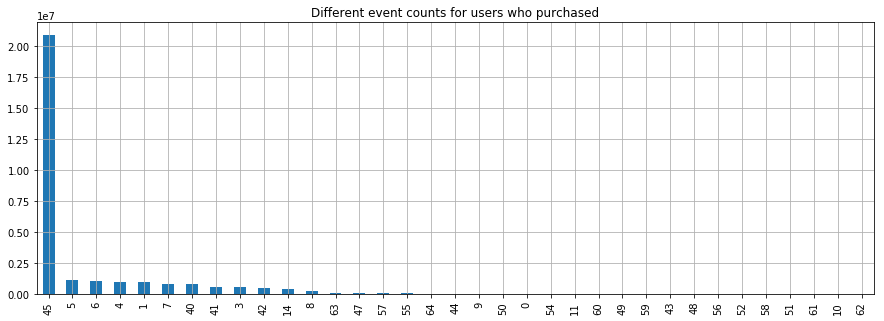

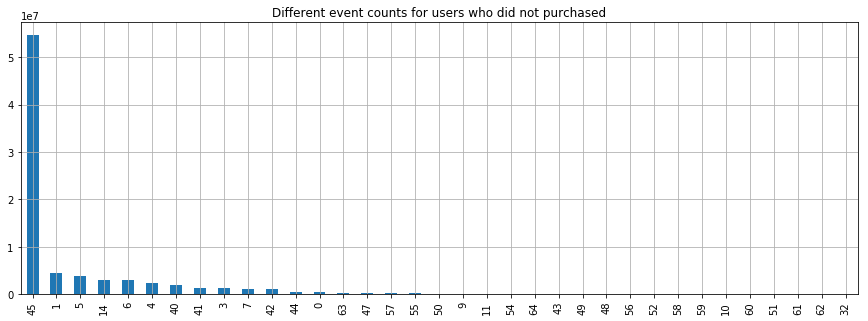

In [20]:
# Users who purchased
plt.figure(figsize=(15,5))
events_purchased.event.value_counts().plot.bar()
plt.title("Different event counts for users who purchased")
plt.grid()
plt.show()
# Users who did not  purchased
plt.figure(figsize=(15,5))
events_not_purchased.event.value_counts().plot.bar()
plt.grid()
plt.title("Different event counts for users who did not purchased")
plt.show()

The distribution of events by the different set of users does not seem a great indicative of for the purchasing behaviour.

Let's plot the different values for each type of user (purchased/not purchased) and the most common events in both groups. 

Event 45
n observations: 20861446


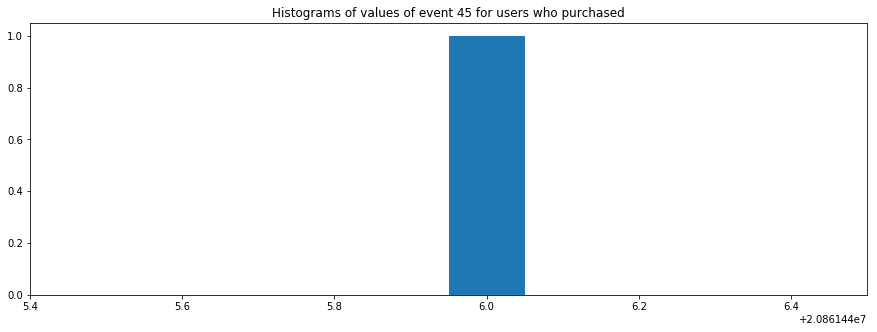

n observations: 54632485


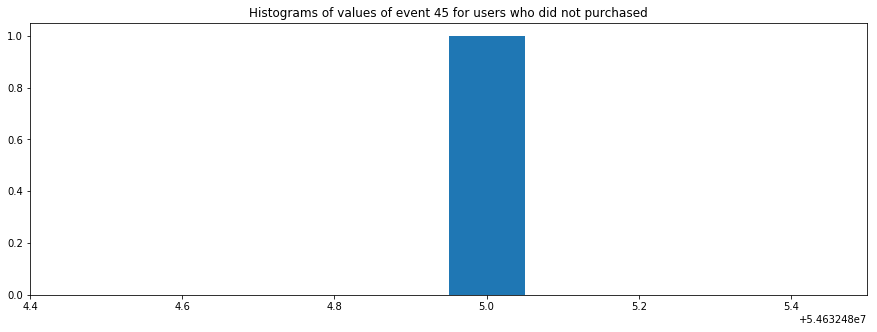

Event 5
n observations: 1160703


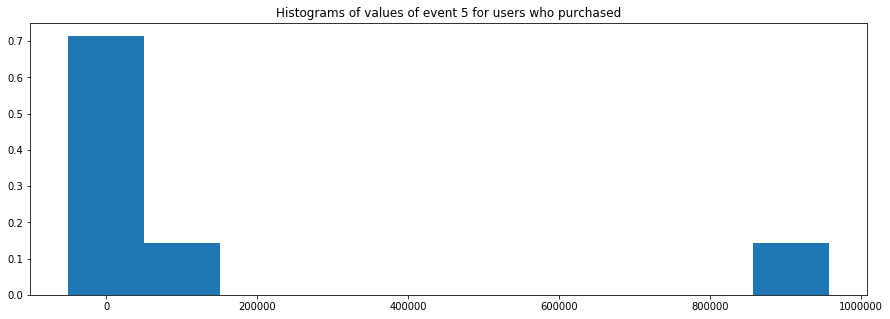

n observations: 3727219


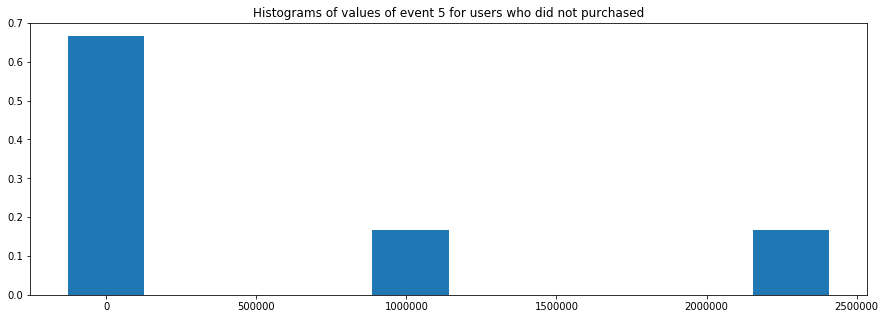

Event 6
n observations: 1085551


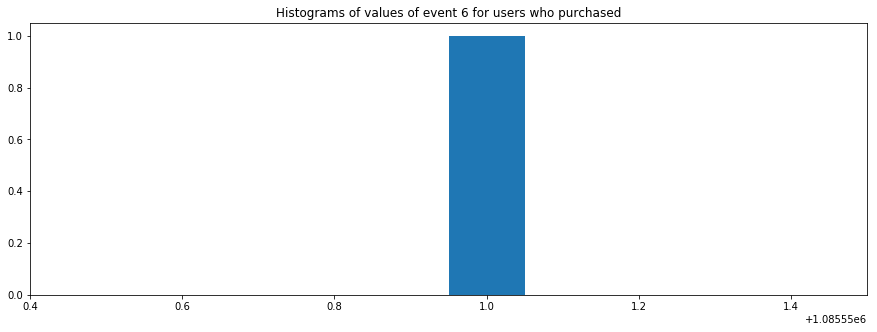

n observations: 2982923


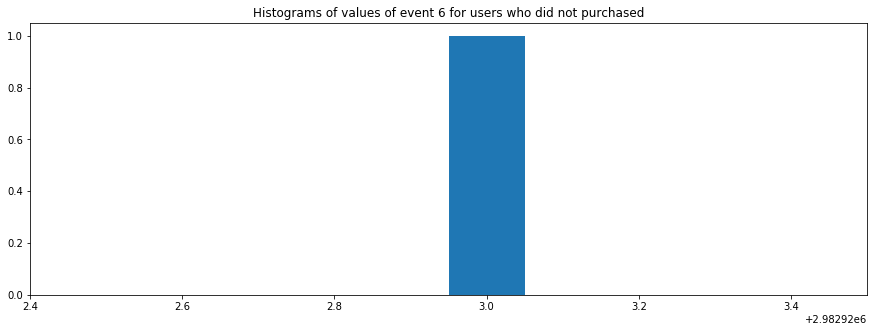

Event 4
n observations: 1004108


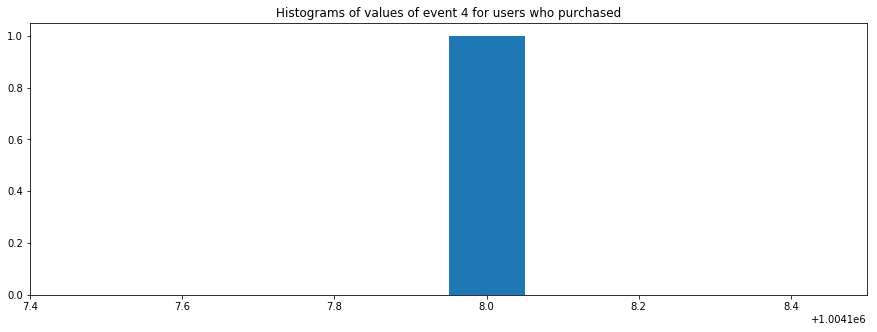

n observations: 2431255


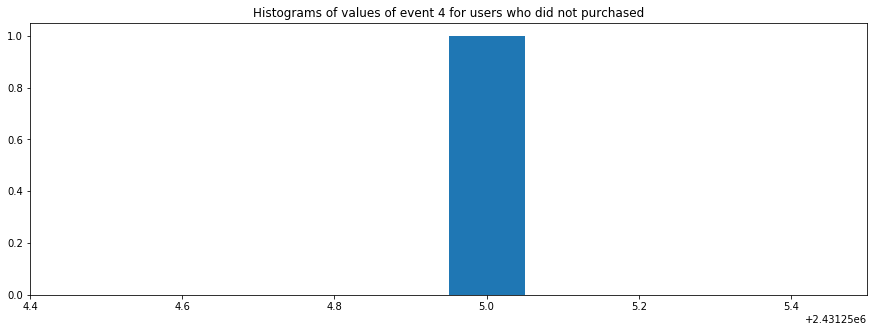

Event 1
n observations: 967641


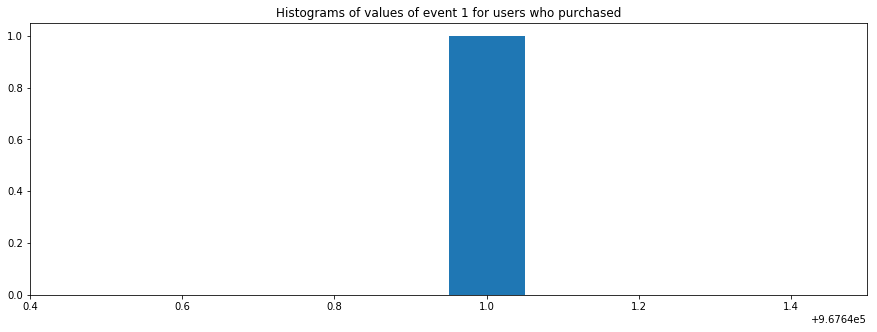

n observations: 4396285


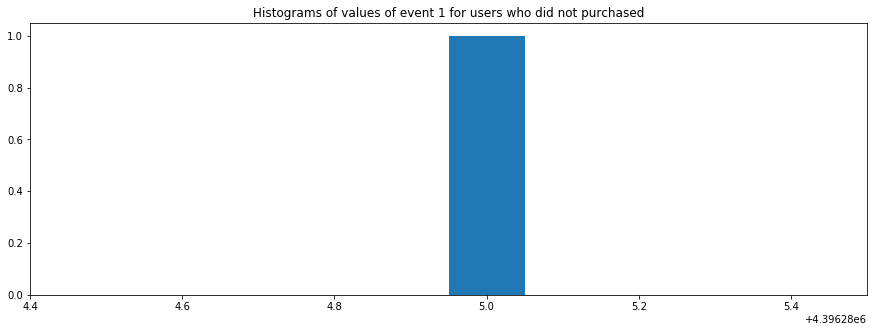

Event 7
n observations: 845537


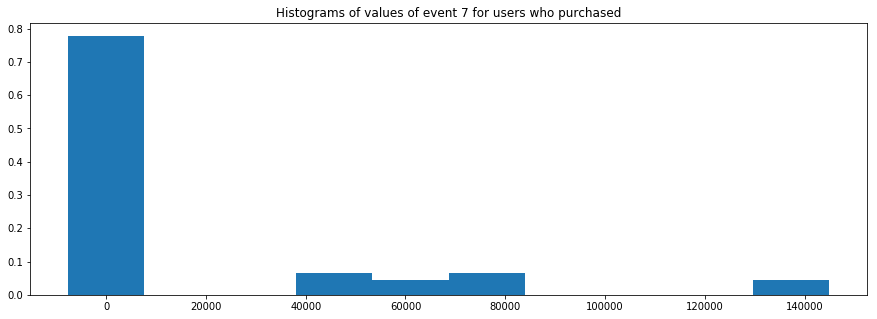

n observations: 1125366


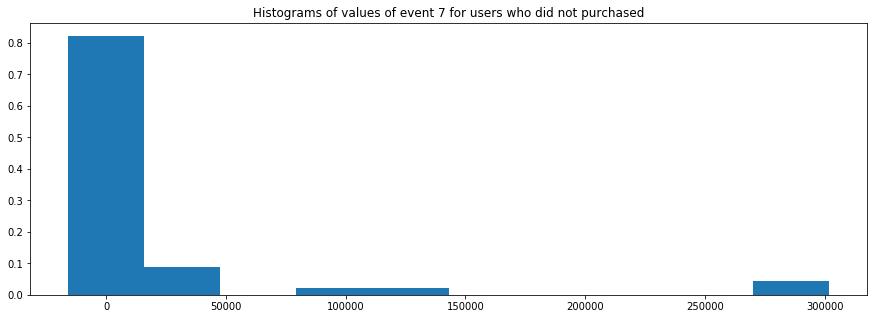

Event 40
n observations: 815743


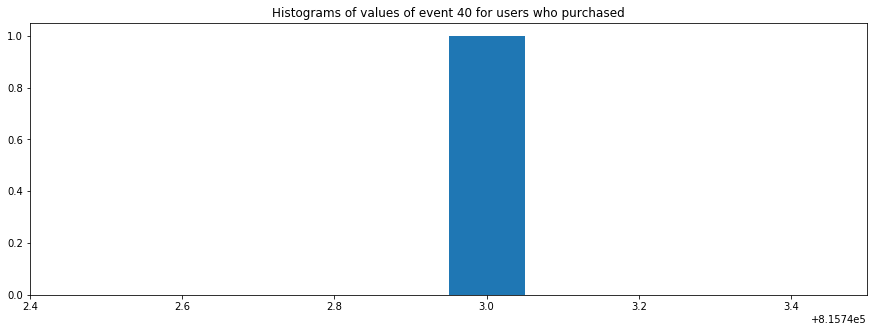

n observations: 1960254


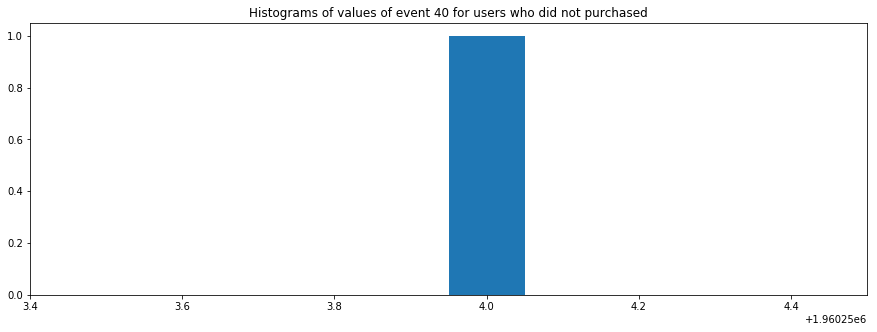

Event 41
n observations: 597622


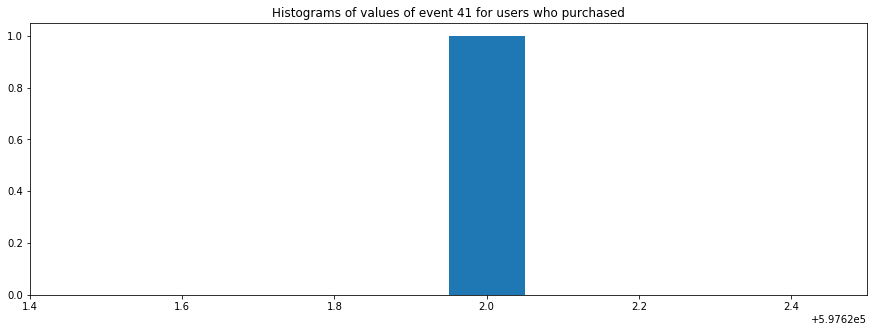

n observations: 1371601


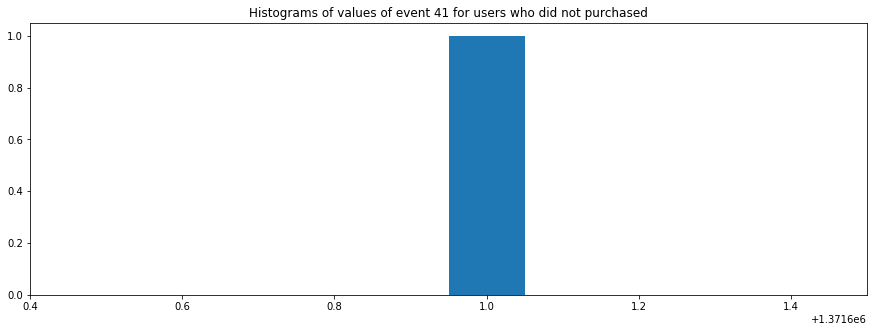

Event 12
n observations: 0


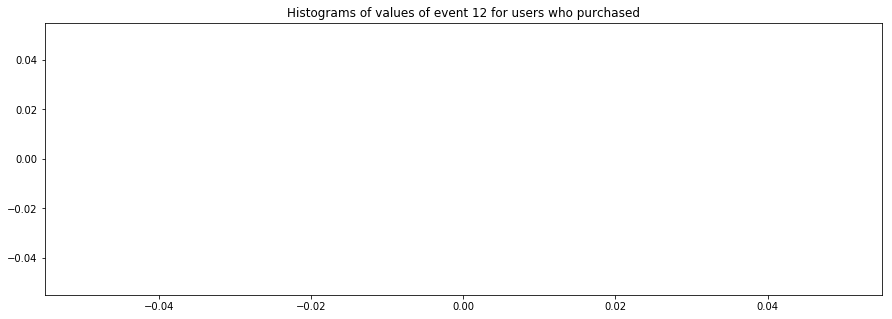

n observations: 0


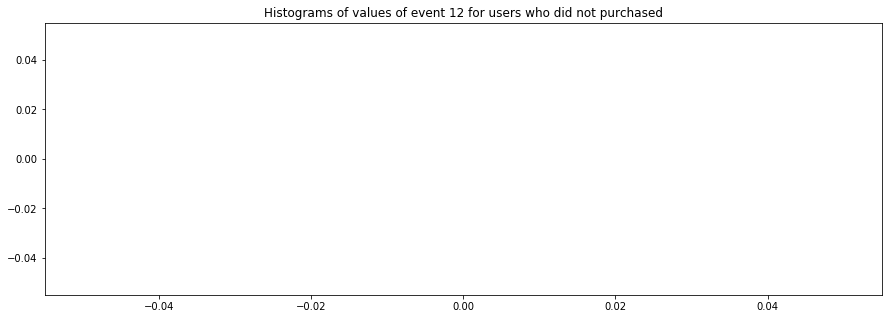

In [33]:
for e in [45,5,6,4,1,7,40,41,12]:
    print(f"Event {str(e)}")
    plt.figure(figsize=(15,5))
    df1 = events_purchased[events_purchased.event==e]
    print(f"n observations: {len(df1)}")
    hist, bins = np.histogram(df1.event_value.value_counts())
    plt.bar(bins[:-1],hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
    plt.title(f'Histograms of values of event {str(e)} for users who purchased')
    plt.show()
    plt.figure(figsize=(15,5))
    df2 = events_not_purchased[events_not_purchased.event==e]
    print(f"n observations: {len(df2)}")
    hist, bins = np.histogram(df2.event_value.value_counts())
    plt.bar(bins[:-1],hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
    plt.title(f'Histograms of values of event {str(e)} for users who did not purchased')
    plt.show()

**Conclusions**

From the event values analyzed above event 5 is the only one that seems to have the potential to provide any kind of discrimination between users that did and did not purchase. 

## On purchases types

In [26]:
avg = len(events_purchased[events_purchased.event==8])/len(events_purchased[events_purchased.event==8].user_id_hash.unique())
print(f'The average amount of times that users buy stuff is {avg}')


The average amount of times that users buy stuff is 7.190700088541508


In [27]:
purchase_transactions = events_purchased[events_purchased.event==8]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 1080x360 with 0 Axes>

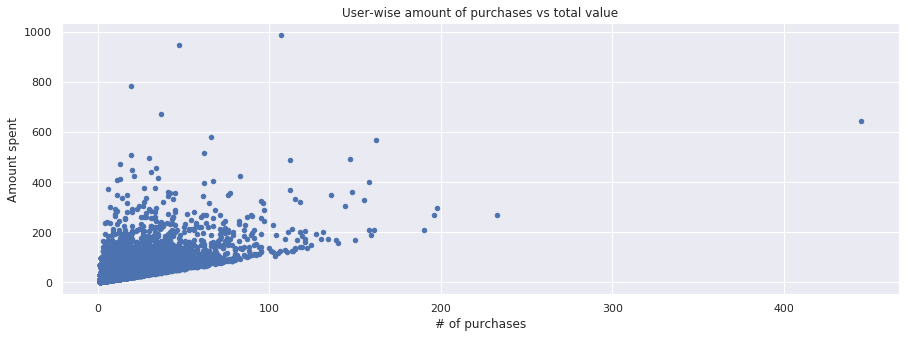

In [137]:
df_count_sum = purchase_transactions.groupby('user_id_hash',as_index=False)['event_value'].agg(['count','sum'])
plt.figure(figsize=(15,5))
df_count_sum.plot.scatter('count', 'sum', figsize=(15,5))
plt.title("User-wise amount of purchases vs total value")
plt.xlabel('# of purchases')
plt.ylabel('Amount spent')
plt.show()

<Figure size 1080x360 with 0 Axes>

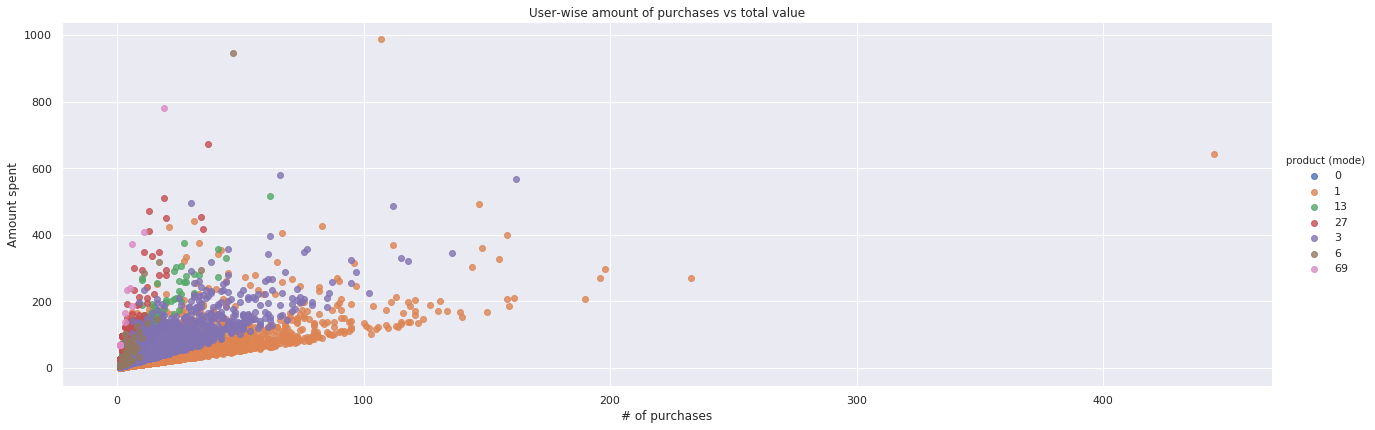

In [138]:
df_count_sum = purchase_transactions.groupby('user_id_hash',as_index=False)['event_value'].agg(['count','sum', lambda x: stats.mode(x)[0][0]])
df_count_sum['product (mode)'] = df_count_sum['<lambda>'].astype('str')
plt.figure(figsize=(15,5))
sns.lmplot(x='count',y='sum', hue='product (mode)', data=df_count_sum, fit_reg=False,size=6, aspect=3)
plt.title("User-wise amount of purchases vs total value by product")
plt.xlabel('# of purchases')
plt.ylabel('Amount spent')
plt.show()

In [139]:
df2 = df_count_sum.copy()
df2['count'] = np.log(df2['count'])
df2['sum'] = np.log(df2['sum']+1)

Text(0.5, 1.0, 'Histogram of the log-scale number of purchases')

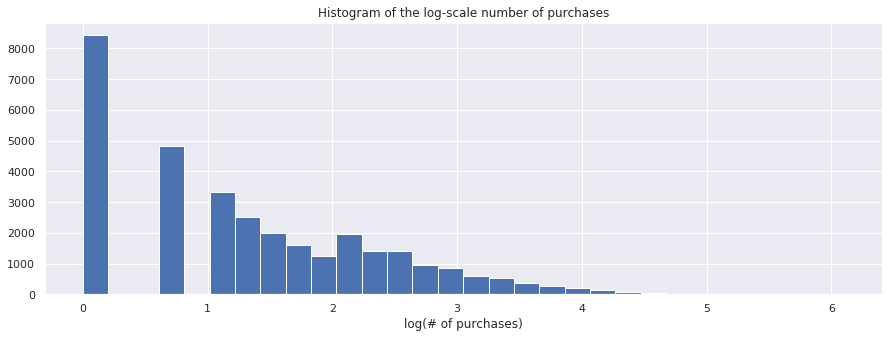

In [140]:
plt.figure(figsize=(15,5))
plt.xlabel('log(# of purchases)')
df2['count'].hist(bins=30)
plt.title('Histogram of the log-scale number of purchases')

Text(0.5, 1.0, 'Histogram of the log-scale amount spent')

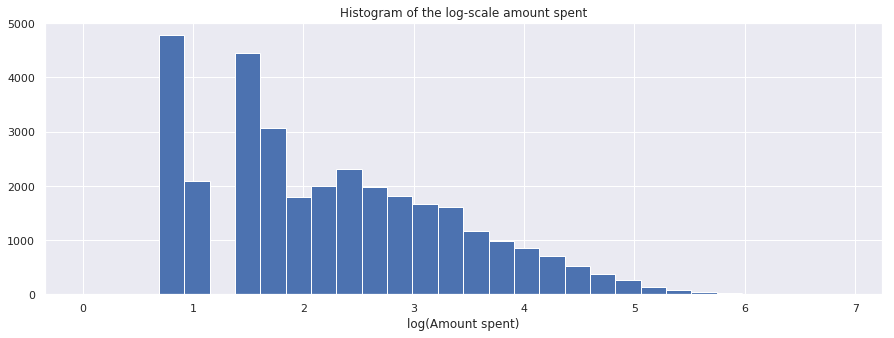

In [141]:
plt.figure(figsize=(15,5))
plt.xlabel('log(Amount spent)')
df2['sum'].hist(bins=30)
plt.title('Histogram of the log-scale amount spent')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


<Figure size 1080x360 with 0 Axes>

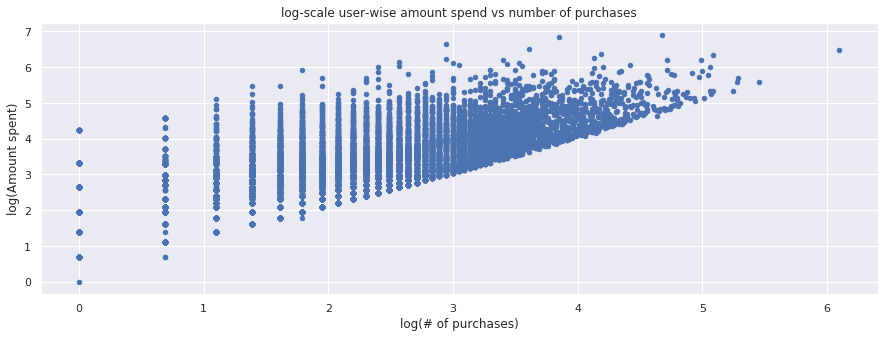

In [142]:
plt.figure(figsize=(15,5))
df2.plot.scatter('count', 'sum', figsize=(15,5))
plt.xlabel('log(# of purchases)')
plt.ylabel('log(Amount spent)')
plt.title('Log-scale user-wise amount spend vs number of purchases')
plt.show()

<Figure size 1080x360 with 0 Axes>

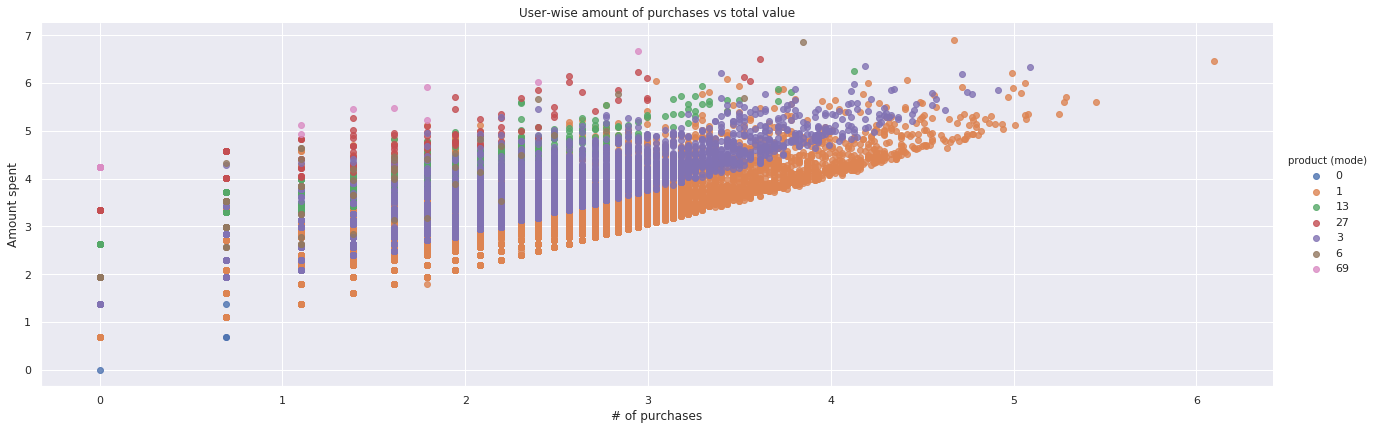

In [143]:
plt.figure(figsize=(15,5))
# plt.scatter(df_count_sum['count'], df_count_sum['sum'], label=df_count_sum['<lambda>'], c= 'red')
sns.lmplot(x='count',y='sum', hue='product (mode)', data=df2, fit_reg=False,size=6, aspect=3)
plt.title("Log-scale user-wise amount spend vs number of purchases by product")
plt.xlabel('# of purchases')
plt.ylabel('Amount spent')
plt.show()

In [10]:
# double-data type count of different events values
purchase_transactions.event_value.value_counts()

1.393000     104975
3.493000      56435
1.393000      35869
3.493000      22136
13.993000      5458
13.993000      4834
6.993000       2160
6.993000       1790
27.993002       914
27.993002       708
69.992996       115
69.992996       109
0.000000         14
Name: event_value, dtype: int64

In [11]:
events_purchased.event_value = events_purchased.event_value.astype(int)

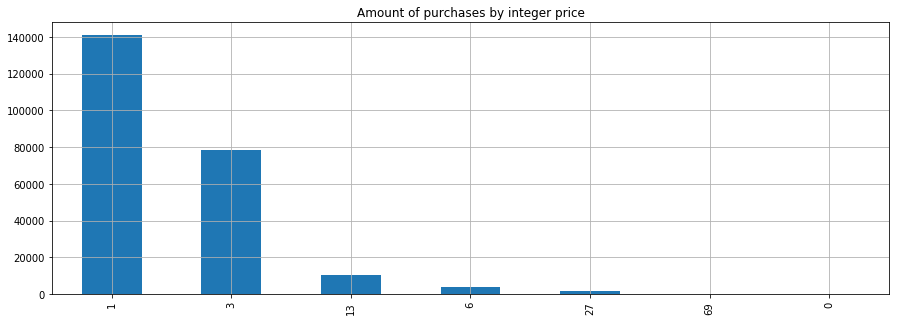

1     140844
3      78571
13     10292
6       3950
27      1622
69       224
0         14
Name: event_value, dtype: int64

In [12]:
# Number of unique kind of purchases
plt.figure(figsize=(15,5))
events_purchased[events_purchased.event==8].event_value.value_counts().plot.bar()
plt.title("Amount of purchases by integer price")
plt.grid()
plt.show()
events_purchased[events_purchased.event==8].event_value.value_counts()

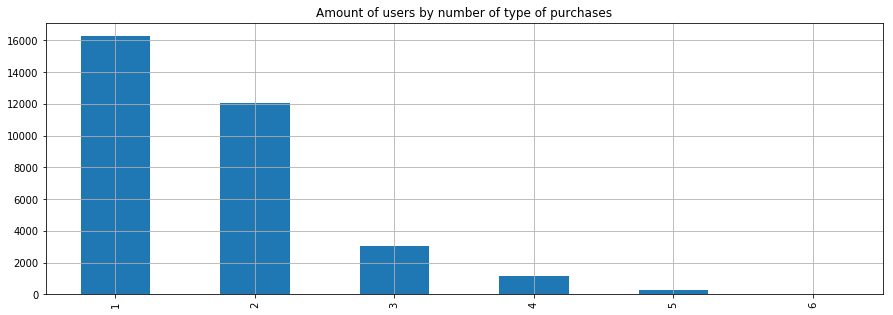

1    16294
2    12019
3     3021
4     1138
5      262
6       19
Name: event_value, dtype: int64

In [13]:
# Number of type of purchases by user
plt.figure(figsize=(15,5))
events_purchased[events_purchased.event==8].groupby('user_id_hash').event_value.nunique().value_counts().plot.bar()
plt.title("Users who bouth x different purchases types")
plt.grid()
plt.show()
events_purchased[events_purchased.event==8].groupby('user_id_hash').event_value.nunique().value_counts()

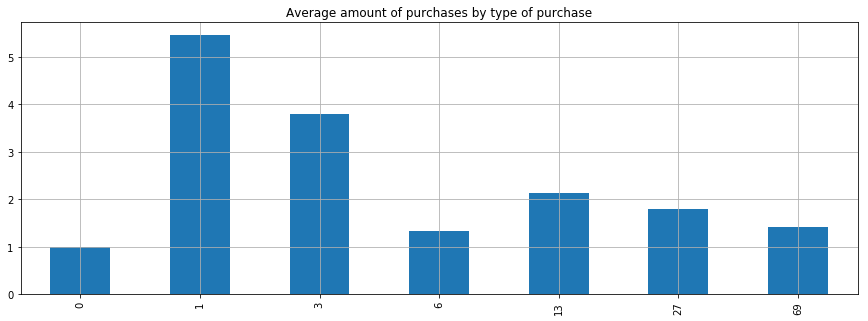

0     1.000000
1     5.457801
3     3.794051
6     1.329966
13    2.139709
27    1.794248
69    1.417722
Name: event_value, dtype: float64

In [22]:
# Number of unique kind of purchases
plt.figure(figsize=(15,5))
purchases_events = events_purchased[events_purchased.event==8]
num = purchases_events.event_value.value_counts().sort_index()
den = np.array([len(purchases_events[purchases_events.event_value==i].user_id_hash.unique()) for i in [0,1,3,6,13,27,69]])
(num/den).plot.bar()
plt.title("Average amount of purchases by type of purchase")
plt.grid()
plt.show()
num/den

**Conclusions**

Take aways here:

1. There are only 7 kinds of purchases (rounding purchase values up to 3  decimals), call the products.
2. The amount of transaction by each of those products is clearly different. Predominating the cheaper ones.
3. Users tend to buy one or two different products. 
4. The density of purchases by user is clearly different over the products.
6. Differentiating between products seems to be useful also for the \$ amount spent - times purchased relationship.


In summary some of those features may help identify what costumer are we dealing with, 


### Sessions

In [48]:
def load_clean_sessions(ts, path='../data/sessions.csv'):
    sessions = pd.read_csv(path)
    sessions = sessions[np.logical_and(sessions.is_session==True,sessions.is_developer==False)]
    sessions.drop(['app_id','is_developer', 'is_session', 'is_wau', 'is_mau', 'device_id'],axis=1,inplace=True)
    sessions['start_timestamp_utc'] = sessions['start_timestamp'] + sessions['timezone_offset']
    sessions = sessions[sessions.start_timestamp_utc < ts]
    sessions.drop('start_timestamp', axis=1, inplace=True)
    sessions['start_dt_utc'] = [datetime.utcfromtimestamp(int(d)) for d in sessions.start_timestamp_utc/1000]
    return sessions
    
sessions = load_clean_sessions(validation_ts_ms)

In [49]:
sessions.head()

,session_id,timezone,timezone_offset,previous_sessions_duration,user_created_timestamp,is_user_first_session,country,region,city,latitude,longitude,locale,os_name,session_index,user_id_hash,start_timestamp_utc
0,5558845121177764917,Asia/Manila,28800000.0,25837591,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,30,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1.542244e+12
2,18781111175537580,Asia/Manila,28800000.0,11343848,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,10,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1.539244e+12
3,1477540082628742048,Asia/Manila,28800000.0,13499724,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,13,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1.540150e+12
4,8184875317380844086,Asia/Manila,28800000.0,32788010,1538874289458,False,PH,00,makati,14.554729,121.024445,en_GB,Android OS,41,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1.542700e+12
5,4706180700083856343,Asia/Manila,28800000.0,5872534,1538874289458,False,PH,11,davao city,7.190708,125.455338,en_GB,Android OS,4,9943447915df3a45fd6720a026af905b6da6b56a37701b...,1.539027e+12


In [67]:
sessions_purchased = sessions[sessions.user_id_hash.isin(purchased_users)]
sessions_not_purchased = sessions[np.logical_not(sessions.user_id_hash.isin(purchased_users))]

In [88]:
sessions_purchased.describe()

,session_id,timezone_offset,previous_sessions_duration,user_created_timestamp,latitude,longitude,session_index,start_timestamp_utc
count,9.954060e+05,9.954060e+05,9.954060e+05,9.954060e+05,995204.000000,995204.000000,995406.000000,9.954060e+05
mean,4.608683e+18,-9.915168e+06,5.410320e+07,1.540497e+12,34.210770,-50.293985,42.617523,1.541370e+12
std,2.663813e+18,1.663543e+07,7.703143e+07,1.356871e+09,19.988075,69.710115,57.338114,1.372854e+09
min,1.809631e+13,-3.960000e+07,0.000000e+00,1.538352e+12,-53.786037,-170.740845,1.000000,1.538342e+12
25%,2.301223e+18,-2.160000e+07,1.044857e+07,1.539381e+12,32.776665,-93.265015,9.000000,1.540276e+12
50%,4.607580e+18,-1.800000e+07,2.832415e+07,1.540315e+12,39.099728,-80.843124,23.000000,1.541440e+12
75%,6.915392e+18,0.000000e+00,6.706074e+07,1.541532e+12,43.637859,-1.345968,53.000000,1.542551e+12
max,9.223359e+18,4.680000e+07,1.606108e+09,1.543622e+12,71.290558,178.450073,938.000000,1.543651e+12


In [89]:
sessions_not_purchased.describe()

,session_id,timezone_offset,previous_sessions_duration,user_created_timestamp,latitude,longitude,session_index,start_timestamp_utc
count,3.539813e+06,3.539813e+06,3.539813e+06,3.539813e+06,3.537683e+06,3.537683e+06,3.539813e+06,3.539813e+06
mean,4.612945e+18,-1.342108e+06,3.034875e+07,1.540681e+12,2.798667e+01,-1.312082e+01,2.947561e+01,1.541301e+12
std,2.663112e+18,1.919634e+07,5.730415e+07,1.419694e+09,2.242204e+01,8.143182e+01,5.341419e+01,1.412409e+09
min,2.335879e+12,-4.320000e+07,0.000000e+00,1.538352e+12,-5.480191e+01,-1.752049e+02,1.000000e+00,1.538349e+12
25%,2.306015e+18,-1.800000e+07,1.573418e+06,1.539468e+12,1.738504e+01,-8.451202e+01,3.000000e+00,1.540148e+12
50%,4.614124e+18,0.000000e+00,9.371763e+06,1.540583e+12,3.405223e+01,-2.761901e+00,1.000000e+01,1.541367e+12
75%,6.920869e+18,1.800000e+07,3.405034e+07,1.541854e+12,4.231494e+01,6.344344e+01,3.300000e+01,1.542528e+12
max,9.223371e+18,5.040000e+07,1.292161e+09,1.543622e+12,7.822318e+01,1.784501e+02,1.159000e+03,1.543651e+12


In [82]:
def bar_plot(df_1,df_2, col, grouped=False):
    # Users who purchased
    plt.figure(figsize=(15,5))
    if grouped: df_1 = df_1.groupby(['user_id_hash'],as_index=False)[col].agg(lambda x:x.value_counts().index[0])
    df_1[col].value_counts(normalize=True).sort_index().plot.bar()
    plt.title("Time zones of users who purchased")
    plt.grid()
    plt.show()
    # Users who did not  purchased
    plt.figure(figsize=(15,5))
    if grouped: df_2 = df_2.groupby(['user_id_hash'],as_index=False)[col].agg(lambda x:x.value_counts().index[0])
    df_2[col].value_counts(normalize=True).sort_index().plot.bar()
    plt.grid()
    plt.title("Time zones of users who did not purchased")
    plt.show()
    

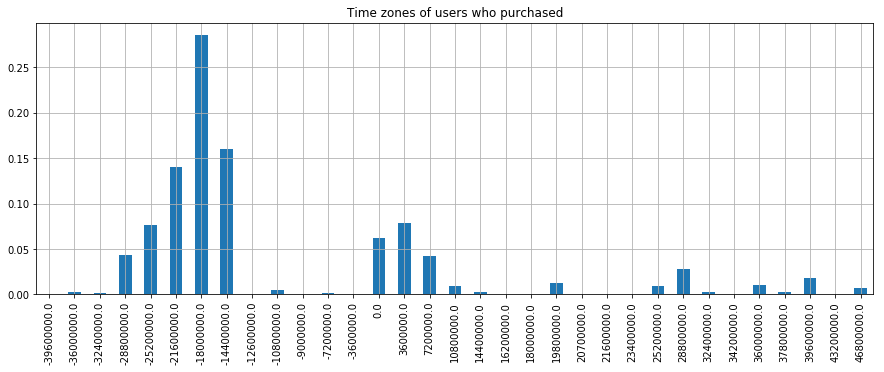

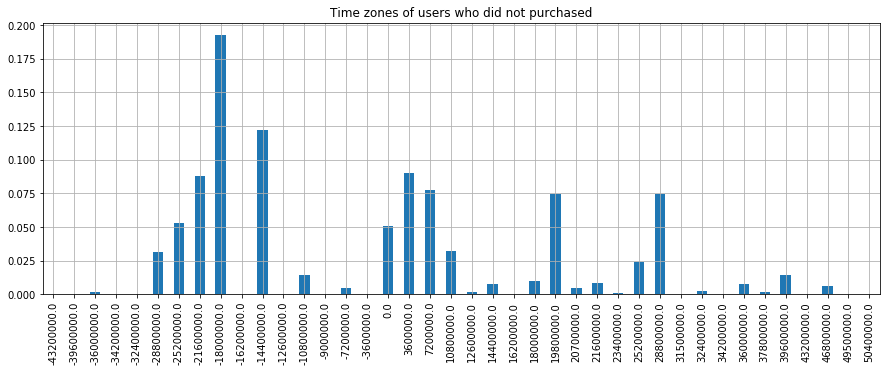

In [84]:
bar_plot(sessions_purchased,sessions_not_purchased, 'timezone_offset', grouped=True)

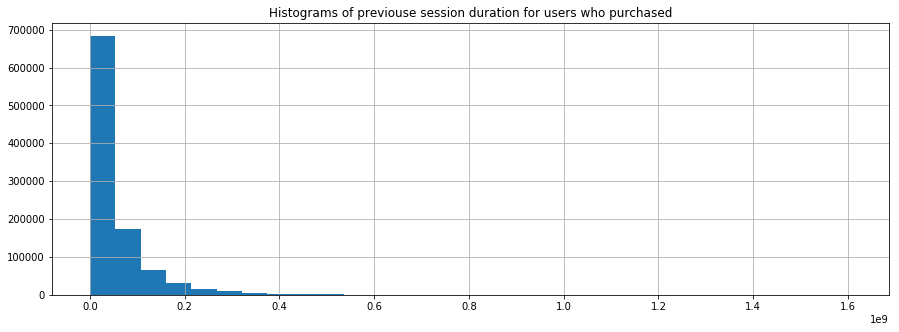

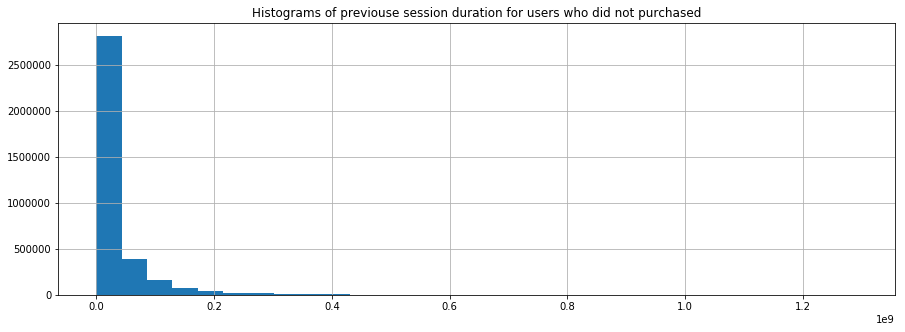

In [97]:
plt.figure(figsize=(15,5))
sessions_purchased.previous_sessions_duration.hist(bins=30)
plt.title(f'Histograms of previouse session duration for users who purchased')
plt.show()
plt.figure(figsize=(15,5))
df2 = events_not_purchased[events_not_purchased.event==e]
sessions_not_purchased.previous_sessions_duration.hist(bins=30)
plt.title(f'Histograms of previouse session duration for users who did not purchased')
plt.show()

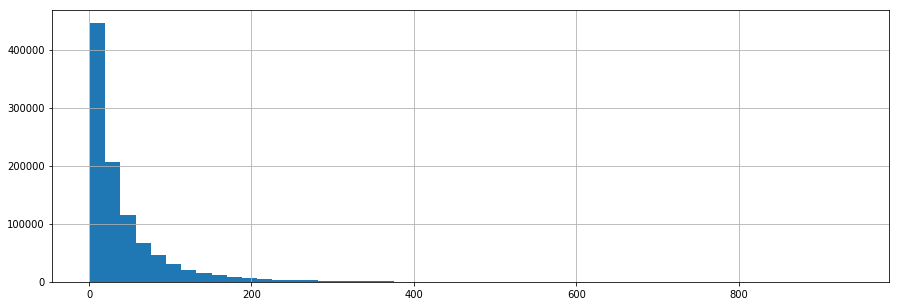

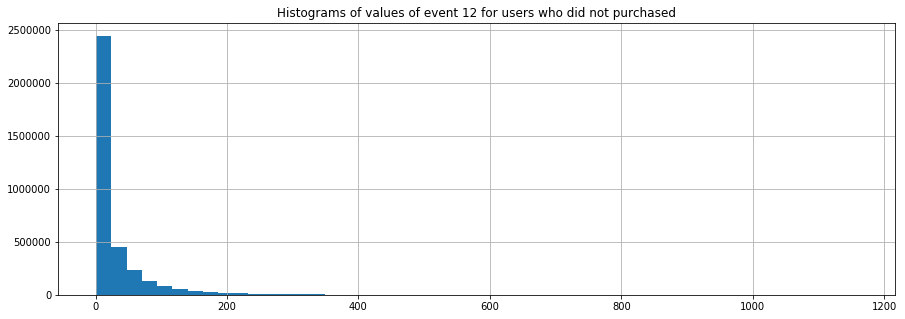

In [95]:
plt.figure(figsize=(15,5))
sessions_purchased.session_index.hist(bins=50)
plt.title(f'Histogram of session indexes for users who did purchased')
plt.show()
plt.figure(figsize=(15,5))
sessions_not_purchased.session_index.hist(bins=50)
plt.title(f'Histogram of session indexes for users who did not purchased')
plt.show()

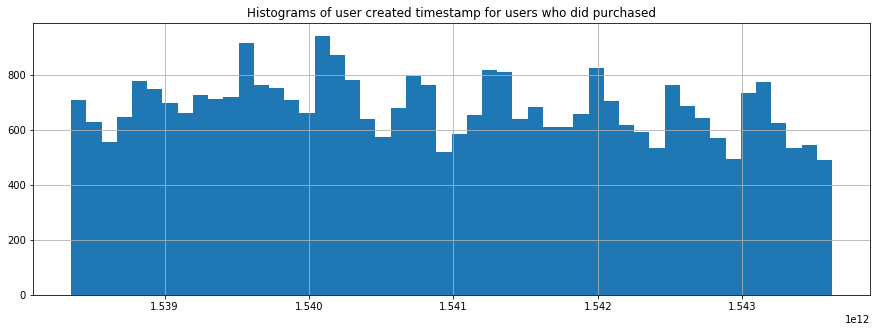

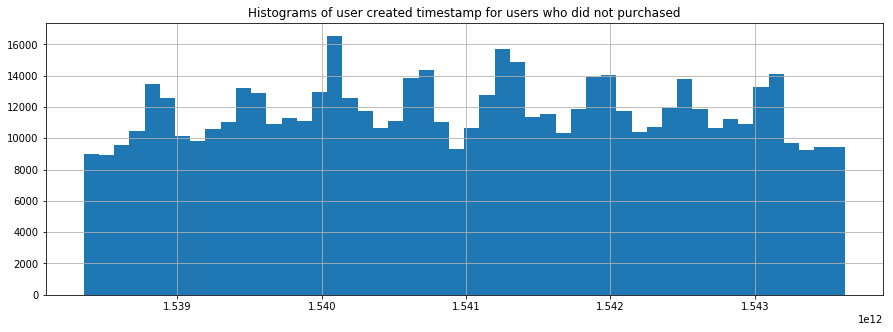

In [100]:
plt.figure(figsize=(15,5))
sessions_purchased.groupby(['user_id_hash'])['user_created_timestamp'].mean().hist(bins=50)
plt.title(f'Histograms of user created timestamp for users who did purchased')
plt.show()
plt.figure(figsize=(15,5))
sessions_not_purchased.groupby(['user_id_hash'])['user_created_timestamp'].mean().hist(bins=50)
plt.title(f'Histograms of user created timestamp for users who did not purchased')
plt.show()

# Conclusion

From this preliminary EDA we infer that there do not appear to be a clear patter to distinguish users who did or did not make a purchase with an untemporal treatment of the data in `events.csv` or `sessions.csv`. 

